# Imports

In [1]:
import numpy as np
%cd ..
# I need this to access modules from the main folder. Do not move this comment up into the same line

import pandas as pd
from tqdm.notebook import tqdm
import swifter
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

from generate_dataframe import generate_sentences_and_meta_df_from_multiple_files
from load_saved_dataframe import load_saved_df
from numerals import *
from concordance import *
from helper_methods import try_apply, drop_na_with_count

C:\Users\karla\PycharmProjects\gender_linguistics_on_ParlaMint


# Set Parameters

In [2]:
save_name = "200_files_2023-02-27"
saving = True
from_saved = False
number_of_files = 200
random_seed = 1341995

# Run

## Load / Generate

In [3]:
if from_saved:
    df = load_saved_df(f"C:/Users/karla/Desktop/Zula_Data_all_in_one/{save_name}.csv")
else:
    df = generate_sentences_and_meta_df_from_multiple_files(number_of_files=number_of_files, random_seed=random_seed)
    if saving:
        df.to_csv(f"C:/Users/karla/Desktop/Zula_Data_all_in_one/{save_name}.csv")

Generating Dataframe:   0%|          | 0/200 [00:00<?, ?it/s]

In [4]:
n_sentences = df.shape[0]
print(f"total # of sentences: {n_sentences}")
df, dropped_due_to_original_nan = drop_na_with_count(df)
print(f"#numbers_dropped_due_to_original_nan: {dropped_due_to_original_nan}")

total # of sentences: 96320
#numbers_dropped_due_to_original_nan: 307


## Numerals

In [5]:
func_arg_res = [(group_nums, 'sentence', 'sentence_grouped_nums'),
             (parse_num_groups, 'sentence_grouped_nums', 'sentence_parsed_num_groups'),
             (num_list, 'sentence_parsed_num_groups', 'NUMs')]
            # function, argument_column, result_column

drops_per_func = {}

for func, arg_col, res_col in func_arg_res:
    func_name = func.__name__
    print(f"Applying {func_name}")
    df[res_col] = df[arg_col].swifter.apply((lambda c: try_apply(func, c)))
    df, drops_per_func[func_name] = drop_na_with_count(df)

print("drop_reason".rjust(16)+" | #sentences_dropped"+"\n"+("="*37))
for func, _, _ in func_arg_res:
    func_name = func.__name__
    print(func_name.rjust(16)+f" | {drops_per_func[func_name]}")

Applying group_nums


Pandas Apply:   0%|          | 0/96013 [00:00<?, ?it/s]

Applying parse_num_groups


Pandas Apply:   0%|          | 0/94700 [00:00<?, ?it/s]

Applying num_list


Pandas Apply:   0%|          | 0/93714 [00:00<?, ?it/s]

     drop_reason | #sentences_dropped
      group_nums | 1313
parse_num_groups | 986
        num_list | 0


In [6]:
df = df.explode('NUMs').reset_index(drop=True)
df['num_index'], placeholder = zip(*df['NUMs'])
(df['num_as_str'], df['num_value']) = zip(*placeholder)
n_numbers = df.shape[0]
print(f"#numbers: {n_numbers}")

#numbers: 142866


In [7]:
df['is_float-like'], df['proper_digits'], df['zeroes'] = zip(*df['num_as_str'].swifter.apply(lambda cell: try_apply(find_roundedness, cell)))

df, dropped_by_find_roundedness = drop_na_with_count(df)

print(f"#numbers_dropped_by_find_roundedness: {dropped_by_find_roundedness}")

Pandas Apply:   0%|          | 0/142866 [00:00<?, ?it/s]

#numbers_dropped_by_find_roundedness: 766


## Statistics

In [8]:
dfs = {'float_likes_only_df': df[df['is_float-like']],
       'int_likes_only_df': df[df['is_float-like'] == False]
       }

binary_independent_variables = {'is_upper_house': ('house', 'lower_house', 'upper_house'),
                    'is_chairperson': ('speaker_role', 'regular', 'chairperson'),
                    'is_mp': ('speaker_type', 'notMP', 'MP'),
                    'is_female': ('gender', 'male', 'female')
                    }
                    # column_name, variable_name, value1 (False), value2 (True)
# TODO: Party_status! -> dropna??!!!!!!!!!!!!!!!!!!!!!!


dependent_variables = ['num_value', 'proper_digits', 'zeroes']
max_dv_name_len = max((len(_dv) for _dv in dependent_variables))

### Binary Independent Variables

In [20]:
for biv in binary_independent_variables.keys():
    print("="*20,"\n",biv,"\n","-"*18)
    print(df[biv].value_counts())

 is_upper_house 
 ------------------
False    86064
True     56036
Name: is_upper_house, dtype: int64
 is_chairperson 
 ------------------
False    140032
True       2068
Name: is_chairperson, dtype: int64
 is_mp 
 ------------------
True    142100
Name: is_mp, dtype: int64
 is_female 
 ------------------
False    104568
True      37532
Name: is_female, dtype: int64


In [10]:
for df_name, _df in dfs.items():
    print(f"{'='*len(df_name)}\n{df_name}\n{'='*len(df_name)}")

    for biv in binary_independent_variables.keys():
        print(f"{'-'*len(biv)}\n{biv}\n{'-'*len(biv)}")

        for dv in dependent_variables:
            ttest_result = st.ttest_ind(_df[_df[biv] == True][dv], _df[_df[biv] == False][dv], equal_var = False)
            print(f"{dv.ljust(max_dv_name_len)}: {ttest_result}")

float_likes_only_df
--------------
is_upper_house
--------------
num_value    : Ttest_indResult(statistic=-1.3154124548641284, pvalue=0.18854853772366284)
proper_digits: Ttest_indResult(statistic=-8.479250244493318, pvalue=4.309960118873803e-17)
zeroes       : Ttest_indResult(statistic=9.8281467898701, pvalue=3.1721333791102615e-22)
--------------
is_chairperson
--------------
num_value    : Ttest_indResult(statistic=-1.4180389816587904, pvalue=0.15629837810017191)
proper_digits: Ttest_indResult(statistic=12.594463751589187, pvalue=9.537500616294538e-19)
zeroes       : Ttest_indResult(statistic=-28.761058447031328, pvalue=2.6670060821194554e-158)
-----
is_mp
-----
num_value    : Ttest_indResult(statistic=nan, pvalue=nan)
proper_digits: Ttest_indResult(statistic=nan, pvalue=nan)
zeroes       : Ttest_indResult(statistic=nan, pvalue=nan)
---------
is_female
---------
num_value    : Ttest_indResult(statistic=-1.368337911646977, pvalue=0.17135552613918745)
proper_digits: Ttest_indResult(sta

### Semi-Binary Independent Variable 'Party_status'

## Plots

### Histograms

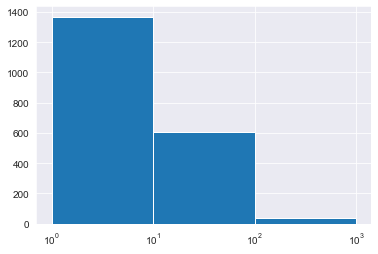

In [11]:
bins = 10**(np.arange(0,4))
plt.xscale('log')
plt.hist(dfs['float_likes_only_df']['num_value'],bins=bins)


plt.show()

float_likes_only_df


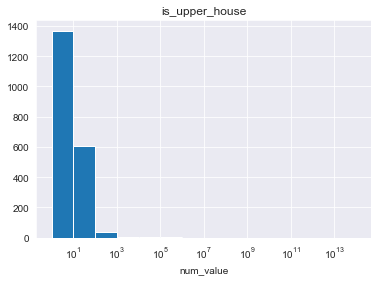

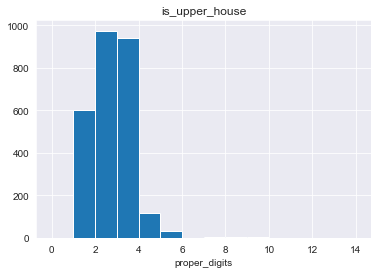

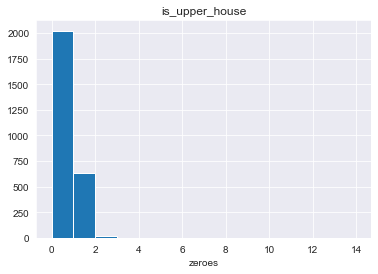

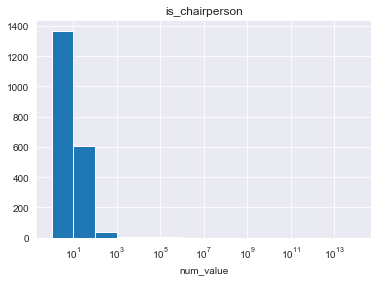

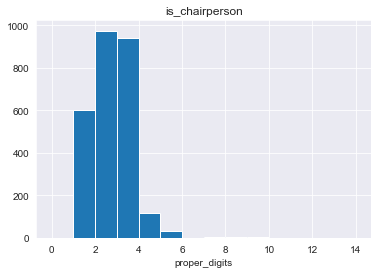

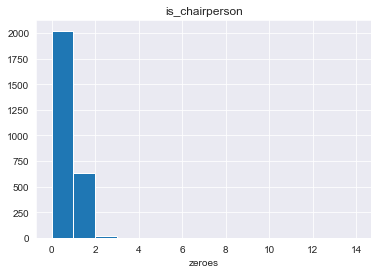

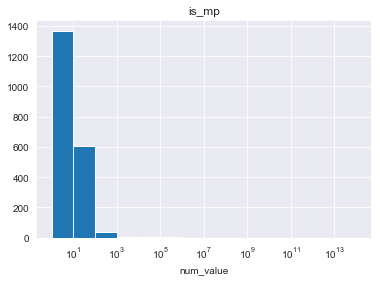

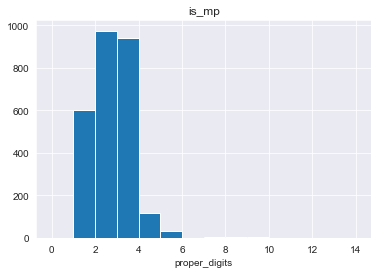

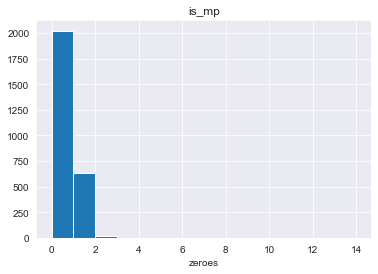

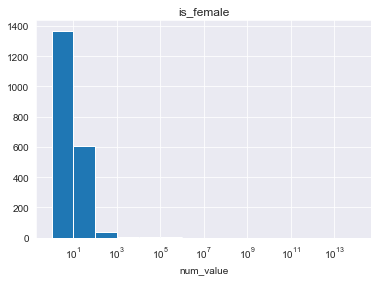

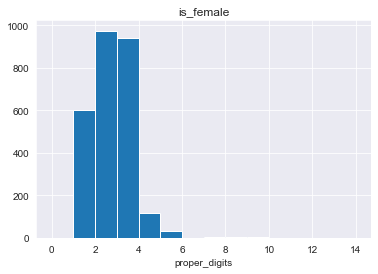

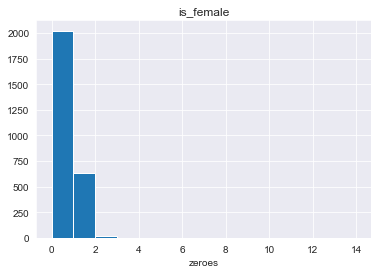

int_likes_only_df


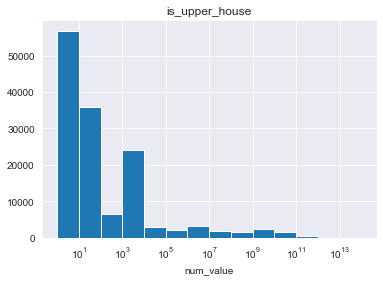

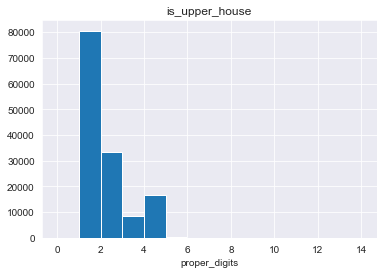

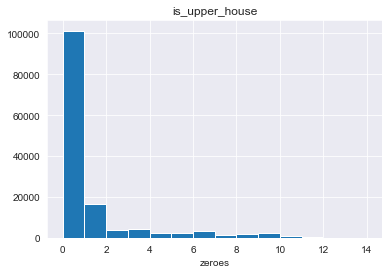

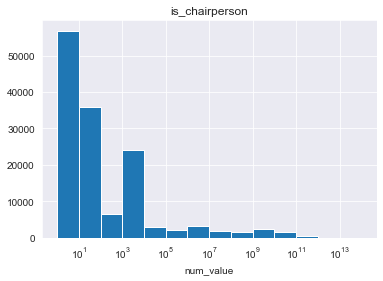

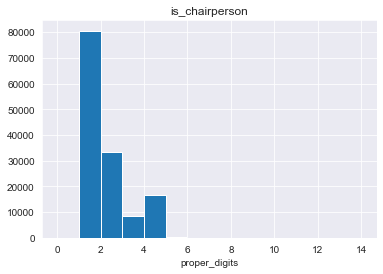

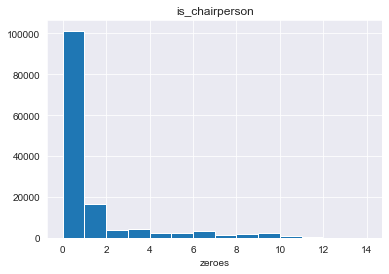

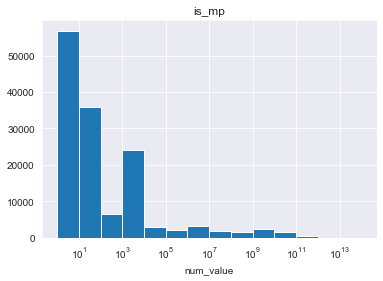

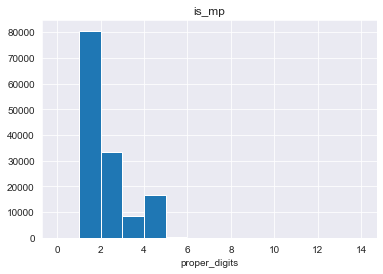

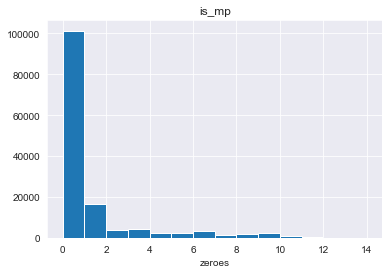

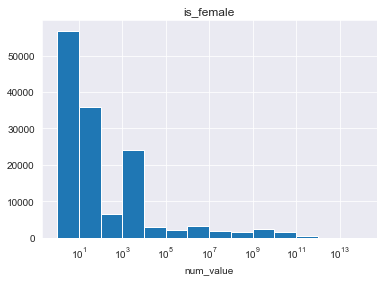

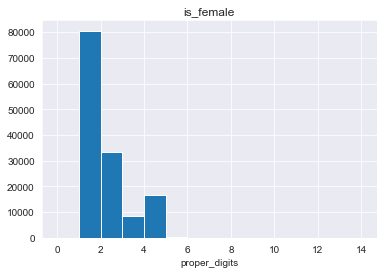

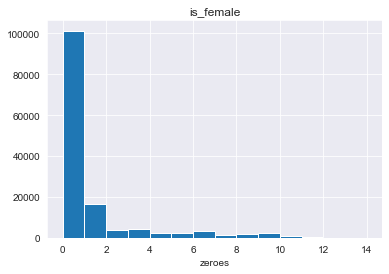

In [12]:
for df_name, _df in dfs.items():
    print(f"{'='*len(df_name)}\n{df_name}\n{'='*len(df_name)}")

    for biv in binary_independent_variables.keys():

        for dv in dependent_variables:
            plt.title(biv)

            if dv == 'num_value':
                plt.xscale('log')
                bins = [10**i for i in range(15)]
            else:
                bins = range(15)

            plt.xlabel(dv)

            plt.hist(_df[dv], bins=bins)

            plt.show()

### Scatterplots

In [13]:
for df_name, _df in dfs.values():
    print(df_name)
    for column_name, ind_variable, value_1, value_2 in col_indvar_v1_v2:
        # TODO: ('Party_status', 'party_status', '?', '??'),
        data = _df.copy()
        data[ind_variable] = np.choose(data[column_name], [value_1, value_2])
        sns.scatterplot(x='num_value', y='zeroes', hue=ind_variable, data=data)
        plt.xscale('log')
        plt.show()

ValueError: too many values to unpack (expected 2)

## Concordance

In [ ]:
df['num_ancestors'] = df.swifter.apply(concordance_ancestors_on_row, axis=1)

In [ ]:
df['num_ancestor_set'] = df['num_ancestors'].swifter.apply(lambda cell: try_apply(ancestry_set, cell))

In [ ]:
if saving:
    df.to_csv(f"C:/Users/karla/Desktop/Zula_Data_all_in_one/{save_name}+group+parsed+separated+exploded+roundedness+ancestors.csv")

In [ ]:
df['num_descendants'] = df.swifter.apply(concordance_descendants_on_row, axis=1)

In [ ]:
df['num_descendant_set'] = df['num_descendants'].swifter.apply(ancestry_set)

In [ ]:
if saving:
    df.to_csv(f"C:/Users/karla/Desktop/Zula_Data_all_in_one/{save_name}+group+parsed+separated+exploded+roundedness+ancestors+descendants.csv")

In [ ]:
value_count_num_descendant_set = df['num_descendant_set'].value_counts()
value_count_num_descendant_set

In [ ]:
value_count_num_ancestor_set = df['num_ancestor_set'].value_counts()
value_count_num_ancestor_set

In [ ]:
float_df = df[df['float-like']]

In [ ]:
int_df = df[df['float-like']==False]

In [ ]:
data = int_df.copy()
sns.scatterplot(x='num_value', y='zeroes', hue='Party_status', data=data)
plt.xscale('log')
plt.show()